## Hodgkin-Huxley model

### intro or smth like that

## Notes for the moment

### Notes on description of model
Models formlates current such that:
* $\displaystyle \sum_{k}^{}$Ik = gNa m^3 h (u - ENa) + gK n^4 (u - EK) + gL (u - EL).

If all channels open, transmit current with max conductance gNa and gK respectively (other channel has constant conductance given as 1/R)

<li>ENa, EK and EL, AND the conducatances are empirical parameters, and are the reversal potentials:
<li><b>Reversal potential:</b> reversal potential of an ion is membrane potential at which no net low of that particular ion fom one side of membrane to the other</li>
<i>Original value of these parameters reported by Hodgkin and Huxley are given on website http://icwww.epfl.ch/~gerstner/SPNM/node14.html.</i><br>
NOTE: need to shift voltage values by -65mV because those were given with a resting potential assumed to be 0, but not the case
</li>

#### m, n and h:
are called the "gating variables" and evolve according to differential eqs (given on websit). Those equations include alpha and beta factors that both are expressions of the membrane volatage mu. 

### Notes on dynamics of model
<li>m and n increase with mu, while h decrease (graph of this to support it)</li>
<li> --> if some external input cause membrane voltage mu to rise, conductance of Na channels increase --> positive Na ions flow into cell and raise even further membrane potential mu. If large enough --> action potential initiated.</li>
<li><b>Threshold type behavior:</b>action potential (which is a traveling spike in membrane potential) is initiated by a peak in current. If that peak in current is not high enough, don't get high large-soike excursion, but just small var. </li>
<li><b>Pulling the membrane voltage back down:</b>the K+ channel is outward so when open, it lowers potential. --> Overall effect is large spike in potential, and then h factor and K+ channel pull it back down (with a temp overshoot since temporarly get potential below rest potential.</li>
<li><b>With constant input current:</b> if I larger than some critical value known (I_theta) observe regular spiking in membrane potential. </li>
<li><b>Step current input:</b> whether triggers action potential or not depends on both the constant current value and the spike value too.</li> 
<li><b>Interesting element, refratoriness:</b> during hyperpolarization period followed action potential due to input current, neuron incapable of reacting to same input current</li>


### What type of current input is associated with vision stimulus from retina? 

#### Additional Notes:
Also need to figure out: <ul>
    <li>Do I have to take into account the what happens with synapses too?</li>
    <li>How much time needed to send response signal once signal reached brain?</li>
    <li>How long is the path from retina to brain and from brain to right arm?</li>
    <li><b>Example situation that will be chosen for project:</b> to make things more dramatic, will assume you are in a boxing match, and see your opponent's arm starting to move towards your face. Assume arm moving at 5 m/s (maybe change that val later), assuming separation between you two is 1.5m, at what distance from your face will arm be when start reacting?</li>
    <li>Ask papa for length of neuronal path, time for brain to analyze signal, what happens in synapses, etc</li>
    </ul>
    
### Setup so far: 
<ul>
    <li>Decided would start by modeling one neuron with length <i>1 cm</i></li>
    <li>Seems like each cicuit represents a part of the axon <b><i>parallel</i></b> to the direction the signal is being transmitted --> pick axon length, number of segments to cut it in, and associate a distinct ciruit with each of those (need to store the different parameters associated with each of them --> make a class that contains all variables need for circuit and make array of instances of that object). </li> 
    <li>What wanna "plot"/see evolve is the membrane voltage. Relation with current given on website --> calculate current to get mu. 

In [1]:
import numpy as np              ## numpy is a library that inclues most of the numerical funciton you will need
import matplotlib.pyplot as plt ## this is the library we use to plot
from math import exp            ## used for diff eq of the Hodgkin-Huxley model

In [2]:
class HHcircuit: # Representation of the circuit of the HH model, physically represents 
                 # membrane and ion channels of a neuron fiber
        
    def __init__(self, gNa, gK, gL, C, mu, E_Na, E_K, E_L): # constructor
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.m = 0.0
        self.n = 0.0
        self.h = 0.0
        self.C = C
        self.mu = mu
        
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        
        self.recorded_mu = []
        
    def update_m(self, dt): # updates m using diff eqs of HH model
        alpha_m = (2.5-0.1*self.mu)/(exp(2.5-0.1*self.mu) - 1)
        beta_m = 4*exp(-self.mu / 18)
        dm = dt * (alpha_m*(1-self.m) - beta_m*self.m)
        self.m += dm
        return self.m
    
    def update_n(self, dt): # updates n using diff eqs of HH model
        alpha_n = (0.1-0.01*self.mu)/(exp(1-0.1*self.mu) - 1)
        beta_n = 0.125*exp(-self.mu / 80)
        dn = dt * (alpha_n*(1-self.n) - beta_n*self.n)
        self.n += dn
        return self.n
    
    def update_h(self, dt): # updates h using diff eqs of HH model
        alpha_h = 0.07*exp(-self.mu / 20)
        beta_h = 1 / (exp(3-0.1*self.mu)+1)
        dh = dt * (alpha_h*(1-self.h) - beta_h*self.h)
        self.h += dh
        return self.h
    
    def sum_I_channels(self): # returns current through capacitor 
        s = 0
        s += self.gNa* (self.m)**3 *self.h*(self.mu-self.E_Na)
        s += self.gK* (self.n)**4 *(self.mu-self.E_K)
        s += self.gL*(self.mu - self.E_L)
        return s

In [3]:
### Numerical values, obtained from experiments

# non shifted values
E_Na = 115.0 # mV
E_K = -12.0
E_L = 10.6
gNa = 120.0 # mS/cm^2
gK = 36.0
gL = 0.3
mu0 = 0.0 # assumes rest potential of membrane is 0mV

# # C_rate = 1.0  # microFarads / cm^2
# C = 2.0 # to verify

In [4]:
def run_experiment(T, I_peak, C): 
    neuron = HHcircuit(gNa, gK, gL, C, mu0, E_Na, E_K, E_L)
    recorded_mu = []
    times = []

    t_steps = 10000
    dt = T / t_steps
    t = 0.0 # ms

    first_pass = False # enables to have a current peak of duration dt only

    #temp 
    I_channels = []

    for i in range(t_steps):
        # update HH model coefficients
        neuron.update_n(dt)
        neuron.update_m(dt)
        neuron.update_h(dt)

        # Update voltage through Capacitor (membrane)
        sum_currents = I_peak - neuron.sum_I_channels()

        d_mu = sum_currents / neuron.C * dt
        neuron.mu += d_mu

        # save and update data
        recorded_mu.append(neuron.mu)
        times.append(t)
        t += dt

        I_channels.append(neuron.sum_I_channels())
        
        # makes sure the current peak is just a pulse of duration dt
        if not first_pass: 
            I_peak = 0.0
            first_pass == True
    
    return recorded_mu, times, I_channels

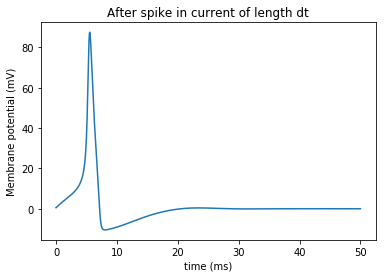

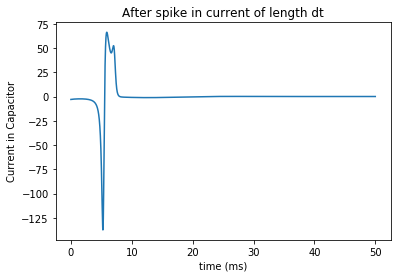

In [5]:
recorded_mu, times, I_channels = run_experiment(50.0, 100.0, 1.0)

plt.plot(times, recorded_mu)
plt.xlabel("time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.title("After spike in current of length dt")
plt.show()

# plt.plot(times, I_out)
plt.plot(times, I_channels)
plt.xlabel("time (ms)")
plt.ylabel("Current in Capacitor")
plt.title("After spike in current of length dt")
plt.show()

In [403]:
# find period of 
def find_period(recorded_mu, times):
    axis_cross = 0
    for i in range(1, len(recorded_mu)-1):
        # checks if 2 values in a row are of different sign (indicates x-axis cross)
        if recorded_mu[i]/recorded_mu[i-1] < 0: 
            axis_cross += 1
        if axis_cross == 2:
            return times[i]
    return 2*times[-1]

def diff_2_peaks(mus1, mus2, times):
    maxV = -1.0
    i1 = 0
#     i2 = 0
    for i in range(len(times)):
        if (mus1[i]>maxV):
            maxV = mus1[i]
            i1 = i
        
        if (mus2[i]==maxV):
            return times[i]-times[i1]
        
def find_period2(recorded_mu, times): 
    max_val = max(recorded_mu)
    axis_cross = False
    
    for i in range(1, len(recorded_mu)):
        # checks if 2 values in a row are of different sign (indicates x-axis cross)
        if recorded_mu[i]/recorded_mu[i-1] < 0: 
            axis_cross = True
        if axis_cross:
#             if abs(recorded_mu[i] - recorded_mu[i-1]) < min_val*10**-8:
            if abs(recorded_mu[i]) < 1.0e-3 and abs(recorded_mu[i-1]) < 1.0e-3:
                return times[i]
    return 2*times[-1]

In [369]:
capacitances = np.linspace(0.5, 10.0, num=50)

periods = []
first = True
times = []

for C_i in capacitances:
    mus, t, _ = run_experiment(100.0, 100.0, C_i)
    if first:
        first = False 
        times = t
    T = find_period(mus, times)
    periods.append(T)

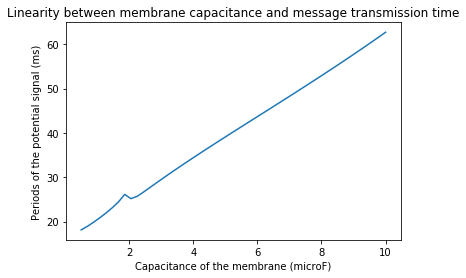

In [294]:
plt.plot(capacitances, periods)
plt.xlabel("Capacitance of the membrane (microF)")
plt.ylabel("Periods of the potential signal (ms)")
plt.title("Linearity between membrane capacitance and message transmission time")
plt.show()

Can see <b>linear relation</b> ... 
Considering neuron fibers of same fiber and diameter, capactance directly proportional to length of neuron fiber. --> can use the period time as a way of measuring time it takes action potential to travel through entire fiber --> given know length of fiberm can obtain speed

BUT small irregularities --> will use several values and average it out

In [295]:
# Calculate slope from previous data 
slope = (periods[-1] - periods[0]) / (capacitances[-1] - capacitances[0])
print(slope)

4.693684210525902


In [296]:
# Scientifically known numerical values
diam_fiber = 2.0e-1 # cm
C_per_area = 1.0 # microF/cm^2

neuron_length = 1.0 # cm 
area = np.pi * diam_fiber * neuron_length # cm^2
C = area * C_per_area # microF/cm^2
period_signal = C * slope # ms 

speed = neuron_length / period_signal # cm / ms
converted_speed = speed*10**-2/10**-3 # m/s
print(speed, converted_speed)
print(area, period_signal)

0.3390831934005694 3.3908319340056945
0.6283185307179586 2.9491287668117163


just make it up

## Trying version with the different circuits

In [408]:
C_per_area = 1.0 # microF/cm^2
diam_fiber = 1.0e-0 # cm
neuron_length = 10.0 # cm 
area = np.pi * diam_fiber * neuron_length # cm^2
C = area * C_per_area # microF/cm^2

I_peak = 1.0

R_cyto_per_L = 00.0 # ohms/cm

L_steps = 50
dL = neuron_length / L_steps
dC = np.pi * diam_fiber * dL * C_per_area

R_L = neuron_length * R_cyto_per_L
dR = dL * R_cyto_per_L

I_central = []
mus_array = []
neurons_array = []


n = HHcircuit(gNa, gK, gL, dC, mu0, E_Na, E_K, E_L)

for i in range(L_steps): 
    neurons_array.append(n)
    mus_array.append([])
    I_central.append(0)

I_central[0] = I_in
times = []
T = 1.0 # ms
t_steps = 100000
dt = T / t_steps
t = 0.0 # ms

I_n50 = [0]

count = 0

for t_i in range(t_steps): 
    
    for x in range(L_steps):
        neuron = neurons_array[x]
#         update HH model coefficients
        neuron.update_n(dt)
        neuron.update_m(dt)
        neuron.update_h(dt)
        # Update voltage through Capacitor (membrane)
        sum_currents = I_central[x] - neuron.sum_I_channels()
        d_mu = sum_currents / neuron.C * dt
        neuron.mu += d_mu

        # save and update data
        neurons_array[x] = neuron
        
#         neuron.update_n(dt)
#         neuron.update_m(dt)
#         neuron.update_h(dt)
        
        mus_array[x].append(neuron.mu)
            
        if x==0: 
            dV_dx = 0.0
            
        else:
            dV_dx = (mus_array[x][-1] - mus_array[x-1][-1]) / dL
        I_central[x] = - dR * dV_dx
        
        if I_central[x] ==0:
            count += 1
        
        if x==50 and t_i>0: 
            I_n50.append(-dR * dV_dx)
        
    times.append(t)
    t += dt
print(count)

5000000


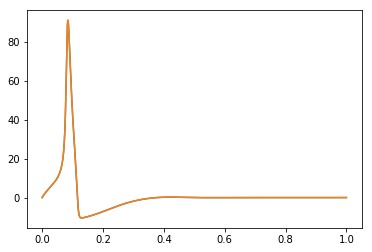

In [409]:
plt.plot(times, mus_array[-1])
plt.plot(times, mus_array[0])
plt.show()

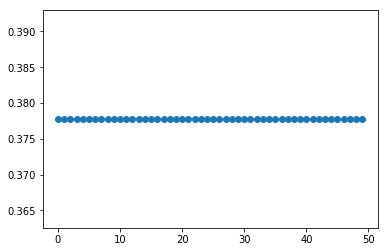

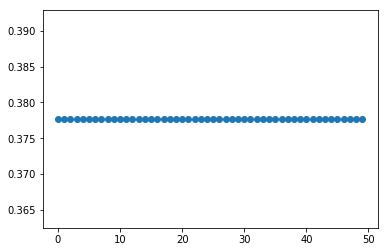

In [410]:
T = []
T2 = []
for mu in mus_array:
    T.append(find_period(mu, times))
    T2.append(find_period2(mu, times))

plt.scatter([i for i in range(L_steps)], T)

plt.show()
plt.scatter([i for i in range(L_steps)], T2)

plt.show()

In [417]:
print(T)
print(T2)
print((neuron_length - dL)/(T2[-1]), dL/T2[0]) # second one works
print(len(times), len(mus_array[0]))

[0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377760000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237, 0.377750000000237]
[0.37768000000023694, 0.37768000000023694, 0.3776

In [412]:
# print(mus_array[0])

print(T[1])
print(dL/T[1])
speed = neuron_length / sum(T)
print(speed)
print(speed*10**-2 / 10**-3)

0.377760000000237
0.5294366793728148
0.5294431264248627
5.294431264248627


In [325]:
diff = diff_2_peaks(mus_array[0], mus_array[-1], times)
print(diff)
# T2 = find_period2(mus_array[0], mus_array[-1], times)
T2 = find_period()
speed2 = neuron_length / T2
print(speed2)

None
206.39834881319175


In [314]:
t = 0
print(mus_array[0][t], mus_array[1][t])

0.0004691887722349076 0.00048364849557543685
